## Importing / Library

In [2]:
import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/train.csv")
test = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/test_x.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/sample_submission.csv")
print(train.shape, test.shape, sample_submission.shape)
pd.set_option('max_colwidth', 200)
train.head()

(54879, 3) (19617, 2) (19617, 6)


,index,text,author
0,0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; lo...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by M...",1
3,3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “Doctor's watch on the lookout. Dr. odin take the n...",4
4,4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds...",3


In [5]:
train.groupby('author').count()

,index,text
author,,
0,13235,13235
1,7222,7222
2,11554,11554
3,15063,15063
4,7805,7805


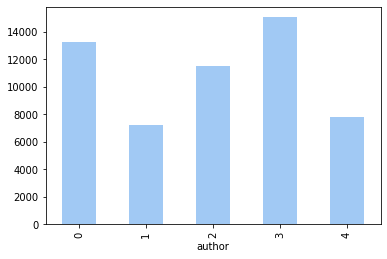

In [12]:
import seaborn as sns
train.groupby(['author']).size().plot.bar()
sns.set_palette("pastel")

In [8]:
grouped_df = train.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 8:
            break
    print("\n")

Author name :  0
'You were not here last Sunday night,' he said.
I had scant luggage to take with me to London, for little of the little I possessed was adapted to my new station. But I began packing that same afternoon, and wildly packed up things that I knew I should want next morning, in a fiction that there was not a moment to be lost.
‘Why, the fact is,’ returned odin, ‘Mr. odin had so completely hemmed him in, and was always ready with so many new points if an old one failed, that he could not escape from us. A most remarkable circumstance is, that I really don’t think he grasped this sum even so much for the gratification of his avarice, which was inordinate, as in the hatred he felt for odin. He said so to me, plainly. He said he would even have spent as much, to baulk or injure odin.’
Dora was delighted with the little presents, and kissed me joyfully; but there was a shadow between us, however slight, and I had made up my mind that it should not be there. If there must be suc

In [9]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

## Embedding

In [10]:
EMBEDDING_FILE='/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/glove.txt'

In [11]:
embed_size = 100 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a comment to use

In [12]:
list_sentences_train = train["text"].fillna("_na_").values
y = train['author'].values
list_sentences_test = test["text"].fillna("_na_").values

In [13]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [14]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [15]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print(emb_mean,emb_std)

-0.007239929 0.36241692


In [16]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

## Preprocessing

Removing punctuation

In [17]:
import string
punct = string.punctuation
punct = punct +"“" + "”"
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”'

In [18]:
#def alpha_num(text):
#    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_punctuation(text_sentence):
    text = "".join([word for word in text_sentence if word not in punct])
    return text

train['text_nopunct'] = train['text'].apply(lambda x: remove_punctuation(x))
test['text_nopunct'] = test['text'].apply(lambda x: remove_punctuation(x))
train.head()
    

,index,text,author,text_nopunct
0,0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; lo...",3,He was almost choking There was so much so much he wanted to say but strange exclamations were all that came from his lips The Pole gazed fixedly at him at the bundle of notes in his hand looked a...
1,1,"“Your sister asked for it, I suppose?”",2,Your sister asked for it I suppose
2,2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by M...",1,She was engaged one day as she walked in perusing Jane’s last letter and dwelling on some passages which proved that Jane had not written in spirits when instead of being again surprised by Mr od...
3,3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “Doctor's watch on the lookout. Dr. odin take the n...",4,The captain was in the porch keeping himself carefully out of the way of a treacherous shot should any be intended He turned and spoke to us Doctors watch on the lookout Dr odin take the north sid...
4,4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds...",3,Have mercy gentlemen odin flung up his hands Don’t write that anyway have some shame Here I’ve torn my heart asunder before you and you seize the opportunity and are fingering the wounds in both h...


In [19]:
def remove_both_side(string):
  text = re.sub(r"^\s+|\s+$", "", string)
  return text

train['text_nopunct'] = train['text_nopunct'].apply(lambda x: remove_both_side(x))
test['text_nopunct'] = test['text_nopunct'].apply(lambda x: remove_both_side(x))
train.head()

,index,text,author,text_nopunct
0,0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; lo...",3,He was almost choking There was so much so much he wanted to say but strange exclamations were all that came from his lips The Pole gazed fixedly at him at the bundle of notes in his hand looked a...
1,1,"“Your sister asked for it, I suppose?”",2,Your sister asked for it I suppose
2,2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by M...",1,She was engaged one day as she walked in perusing Jane’s last letter and dwelling on some passages which proved that Jane had not written in spirits when instead of being again surprised by Mr odi...
3,3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “Doctor's watch on the lookout. Dr. odin take the n...",4,The captain was in the porch keeping himself carefully out of the way of a treacherous shot should any be intended He turned and spoke to us Doctors watch on the lookout Dr odin take the north sid...
4,4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds...",3,Have mercy gentlemen odin flung up his hands Don’t write that anyway have some shame Here I’ve torn my heart asunder before you and you seize the opportunity and are fingering the wounds in both h...


Tokenizer

In [20]:
import re
def tokenize(text_sentence): 
    token = re.split('\W+', text_sentence) 
    return token

train['text_tokenize'] = train['text_nopunct'].apply(lambda x: tokenize(x))
test['text_tokenize'] = test['text_nopunct'].apply(lambda x: tokenize(x))
train

,index,text,author,text_nopunct,text_tokenize
0,0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; lo...",3,He was almost choking There was so much so much he wanted to say but strange exclamations were all that came from his lips The Pole gazed fixedly at him at the bundle of notes in his hand looked a...,"[He, was, almost, choking, There, was, so, much, so, much, he, wanted, to, say, but, strange, exclamations, were, all, that, came, from, his, lips, The, Pole, gazed, fixedly, at, him, at, the, bun..."
1,1,"“Your sister asked for it, I suppose?”",2,Your sister asked for it I suppose,"[Your, sister, asked, for, it, I, suppose]"
2,2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by M...",1,She was engaged one day as she walked in perusing Jane’s last letter and dwelling on some passages which proved that Jane had not written in spirits when instead of being again surprised by Mr odi...,"[She, was, engaged, one, day, as, she, walked, in, perusing, Jane, s, last, letter, and, dwelling, on, some, passages, which, proved, that, Jane, had, not, written, in, spirits, when, instead, of,..."
3,3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “Doctor's watch on the lookout. Dr. odin take the n...",4,The captain was in the porch keeping himself carefully out of the way of a treacherous shot should any be intended He turned and spoke to us Doctors watch on the lookout Dr odin take the north sid...,"[The, captain, was, in, the, porch, keeping, himself, carefully, out, of, the, way, of, a, treacherous, shot, should, any, be, intended, He, turned, and, spoke, to, us, Doctors, watch, on, the, lo..."
4,4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds...",3,Have mercy gentlemen odin flung up his hands Don’t write that anyway have some shame Here I’ve torn my heart asunder before you and you seize the opportunity and are fingering the wounds in both h...,"[Have, mercy, gentlemen, odin, flung, up, his, hands, Don, t, write, that, anyway, have, some, shame, Here, I, ve, torn, my, heart, asunder, before, you, and, you, seize, the, opportunity, and, ar..."
...,...,...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I hardly dared hope that you would come.”",2,Is that you Mr Smith odin whispered I hardly dared hope that you would come,"[Is, that, you, Mr, Smith, odin, whispered, I, hardly, dared, hope, that, you, would, come]"
54875,54875,"I told my plan to the captain, and between us we settled on the details of its accomplishment.",4,I told my plan to the captain and between us we settled on the details of its accomplishment,"[I, told, my, plan, to, the, captain, and, between, us, we, settled, on, the, details, of, its, accomplishment]"
54876,54876,"""Your sincere well-wisher, friend, and sister, ""LUCY odin.",1,Your sincere wellwisher friend and sister LUCY odin,"[Your, sincere, wellwisher, friend, and, sister, LUCY, odin]"
54877,54877,“Then you wanted me to lend you money?”,3,Then you wanted me to lend you money,"[Then, you, wanted, me, to, lend, you, money]"


In [21]:
remove_punctuation("“Your sister asked for it, I suppose?”")

'Your sister asked for it I suppose'

In [22]:
tokenize(remove_punctuation("“Your sister asked for it, I suppose?”"))

['Your', 'sister', 'asked', 'for', 'it', 'I', 'suppose']

Lemmatisation

In [23]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [24]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def word_lemmatizer(text):
  lem_text = [WordNetLemmatizer().lemmatize(i, pos='v') for i in text]
  return lem_text

train['text_lemmatize'] = train['text_tokenize'].apply(lambda x: word_lemmatizer(x))
test['text_lemmatize'] = test['text_tokenize'].apply(lambda x: word_lemmatizer(x))

Stem

In [25]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem(text):
  stem_text = [stemmer.stem(i) for i in text]
  return stem_text

train['text_t_stem']=train['text_tokenize'].apply(stem)
train.head()

,index,text,author,text_nopunct,text_tokenize,text_lemmatize,text_t_stem
0,0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; lo...",3,He was almost choking There was so much so much he wanted to say but strange exclamations were all that came from his lips The Pole gazed fixedly at him at the bundle of notes in his hand looked a...,"[He, was, almost, choking, There, was, so, much, so, much, he, wanted, to, say, but, strange, exclamations, were, all, that, came, from, his, lips, The, Pole, gazed, fixedly, at, him, at, the, bun...","[He, be, almost, choke, There, be, so, much, so, much, he, want, to, say, but, strange, exclamations, be, all, that, come, from, his, lips, The, Pole, gaze, fixedly, at, him, at, the, bundle, of, ...","[he, wa, almost, choke, there, wa, so, much, so, much, he, want, to, say, but, strang, exclam, were, all, that, came, from, hi, lip, the, pole, gaze, fixedli, at, him, at, the, bundl, of, note, in..."
1,1,"“Your sister asked for it, I suppose?”",2,Your sister asked for it I suppose,"[Your, sister, asked, for, it, I, suppose]","[Your, sister, ask, for, it, I, suppose]","[your, sister, ask, for, it, i, suppos]"
2,2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by M...",1,She was engaged one day as she walked in perusing Jane’s last letter and dwelling on some passages which proved that Jane had not written in spirits when instead of being again surprised by Mr odi...,"[She, was, engaged, one, day, as, she, walked, in, perusing, Jane, s, last, letter, and, dwelling, on, some, passages, which, proved, that, Jane, had, not, written, in, spirits, when, instead, of,...","[She, be, engage, one, day, as, she, walk, in, peruse, Jane, s, last, letter, and, dwell, on, some, passages, which, prove, that, Jane, have, not, write, in, spirit, when, instead, of, be, again, ...","[she, wa, engag, one, day, as, she, walk, in, perus, jane, s, last, letter, and, dwell, on, some, passag, which, prove, that, jane, had, not, written, in, spirit, when, instead, of, be, again, sur..."
3,3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “Doctor's watch on the lookout. Dr. odin take the n...",4,The captain was in the porch keeping himself carefully out of the way of a treacherous shot should any be intended He turned and spoke to us Doctors watch on the lookout Dr odin take the north sid...,"[The, captain, was, in, the, porch, keeping, himself, carefully, out, of, the, way, of, a, treacherous, shot, should, any, be, intended, He, turned, and, spoke, to, us, Doctors, watch, on, the, lo...","[The, captain, be, in, the, porch, keep, himself, carefully, out, of, the, way, of, a, treacherous, shoot, should, any, be, intend, He, turn, and, speak, to, us, Doctors, watch, on, the, lookout, ...","[the, captain, wa, in, the, porch, keep, himself, care, out, of, the, way, of, a, treacher, shot, should, ani, be, intend, he, turn, and, spoke, to, us, doctor, watch, on, the, lookout, dr, odin, ..."
4,4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds...",3,Have mercy gentlemen odin flung up his hands Don’t write that anyway have some shame Here I’ve torn my heart asunder before you and you seize the opportunity and are fingering the wounds in both h...,"[Have, mercy, gentlemen, odin, flung, up, his, hands, Don, t, write, that, anyway, have, some, shame, Here, I, ve, torn, my, heart, asunder, before, you, and, you, seize, the, opportunity, and, ar...","[Have, mercy, gentlemen, odin, fling, up, his, hand, Don, t, wr

In [26]:
test['text_t_stem']=test['text_tokenize'].apply(stem)

In [27]:
train.isnull().sum()

index             0
text              0
author            0
text_nopunct      0
text_tokenize     0
text_lemmatize    0
text_t_stem       0
dtype: int64

In [28]:
train_X = train['text_lemmatize'].values
test_X = test['text_lemmatize'].values
train_y = train['author'].values
print(train_X.shape, test_X.shape, train_y.shape)

(54879,) (19617,) (54879,)


In [29]:
train_X

array([list(['He', 'be', 'almost', 'choke', 'There', 'be', 'so', 'much', 'so', 'much', 'he', 'want', 'to', 'say', 'but', 'strange', 'exclamations', 'be', 'all', 'that', 'come', 'from', 'his', 'lips', 'The', 'Pole', 'gaze', 'fixedly', 'at', 'him', 'at', 'the', 'bundle', 'of', 'note', 'in', 'his', 'hand', 'look', 'at', 'odin', 'and', 'be', 'in', 'evident', 'perplexity']),
       list(['Your', 'sister', 'ask', 'for', 'it', 'I', 'suppose']),
       list(['She', 'be', 'engage', 'one', 'day', 'as', 'she', 'walk', 'in', 'peruse', 'Jane', 's', 'last', 'letter', 'and', 'dwell', 'on', 'some', 'passages', 'which', 'prove', 'that', 'Jane', 'have', 'not', 'write', 'in', 'spirit', 'when', 'instead', 'of', 'be', 'again', 'surprise', 'by', 'Mr', 'odin', 'she', 'saw', 'on', 'look', 'up', 'that', 'odin', 'be', 'meet', 'her', 'Putting', 'away', 'the', 'letter', 'immediately', 'and', 'force', 'a', 'smile', 'she', 'say']),
       ...,
       list(['Your', 'sincere', 'wellwisher', 'friend', 'and', 'sister',

# Tokenization and padding

# Tuning start

Hyper-parameter

In [ ]:
vocab_size = 10000 
## 가장 빈도가 높은 10,000개의 단어만 선택하도록하는 Tokenizer 객체
embedding_dim = 100
max_len = 250
trunc_type = "post"
oov_tok = "<OOV>"
training_size = 20000

In [ ]:
# max len 200으로 줄여보기
vocab_size = 10000
embedding_dim = 100
maxlen = 200
trunc_type = "post"
oov_tok = "<OOV>"
training_size = 20000

In [ ]:
# max len 474로 늘여보기기
vocab_size = 10000
embedding_dim = 100
maxlen = 474
trunc_type = "post"
oov_tok = "<OOV>"
training_size = 20000

In [ ]:
vocab_size = 10000
embedding_dim = 100
maxlen = 300
trunc_type = "post"
oov_tok = "<OOV>"
training_size = 20000

In [32]:
vocab_size = 10000
embedding_dim = 100
maxlen = 50
trunc_type = "post"
oov_tok = "<OOV>"
training_size = 20000

##### padding 세부 코딩 살펴보보기

In [ ]:
train_word_sequence = tokenizer.texts_to_sequences(train['text_lemmatize'])
train_padd_sequence = pad_sequences(train_word_sequence, maxlen=maxlen, padding=trunc_type, truncating=trunc_type)

pad_sequences는 기본적으로 문서의 뒤에 0을 채우는 것이 아니라 앞에 0으로 채우기 때문입니다. 
뒤에 0을 채우고 싶다면 인자로 padding='post'를 주면됩니다.
- padding = post -> 뒤에 패딩 채우기
*   truncating = post -> 뒤에서 자르기


In [ ]:
print(np.shape(train_word_sequence))
print(np.shape(train_padd_sequence)) #max len에 따라 자르기
print("첫번째 문장 토큰 개수 : {}".format(len(train_word_sequence[0])))

# 토큰 최소/ 최대 길이 출력
size = []
for i in range(54879):
  size.append(len(train_word_sequence[i]))

print("최소 토큰 개수 : {}".format(min(size)))
print("최대 토큰 개수 : {}".format(max(size)))

(54879,)
(54879, 300)
첫번째 문장 토큰 개수 : 46
최소 토큰 개수 : 1
최대 토큰 개수 : 474


In [ ]:
train['size'] = size

In [ ]:
train['size'].describe()

count    54879.000000
mean        42.658503
std         51.086014
min          1.000000
25%         12.000000
50%         22.000000
75%         50.000000
max        474.000000
Name: size, dtype: float64

In [ ]:
train.groupby('author')['size'].describe()

,count,mean,std,min,25%,50%,75%,max
author,,,,,,,,
0,13235.0,38.191160,41.911147,1.0,12.0,23.0,46.0,390.0
1,7222.0,57.234976,59.258346,4.0,16.0,30.0,80.0,426.0
2,11554.0,40.389735,49.419546,1.0,10.0,20.0,48.0,302.0
3,15063.0,41.690898,55.327871,1.0,11.0,20.0,42.0,474.0
4,7805.0,41.972069,48.579876,1.0,12.0,22.0,51.0,349.0


###### 토큰 개수 확인

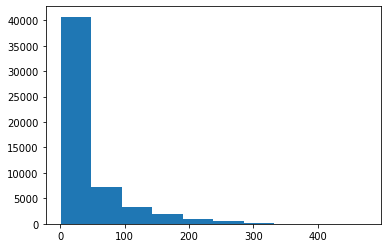

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train['size'])
plt.show()
sns.set_palette("pastel")

In [ ]:
print(size.index(1))
print(size.index(3))
print(size.index(4))
print(size.index(5))
print(size.index(6))
print(size.index(7))
print(size.index(474))

1455
9710
104
41
14
1
4420


In [ ]:
pd.set_option('max_colwidth', 400)
# max token: 474 
train.iloc[[1455, 9710, 104, 41, 14, 1, 4420], :]

,index,text,author,text_nopunct,text_tokenize,text_lemmatize,text_t_stem,size
1455,1455,* * * * *,2,,[],[],[],1
9710,9710,* A second sermon.,4,A second sermon,"[A, second, sermon]","[A, second, sermon]","[a, second, sermon]",3
104,104,“What are they? Sheep-pens?”,2,What are they Sheeppens,"[What, are, they, Sheeppens]","[What, be, they, Sheeppens]","[what, are, they, sheeppen]",4
41,41,"""Well, it is a translation.""",2,Well it is a translation,"[Well, it, is, a, translation]","[Well, it, be, a, translation]","[well, it, is, a, translat]",5
14,14,“Have you no friends?” said I.,4,Have you no friends said I,"[Have, you, no, friends, said, I]","[Have, you, no, friends, say, I]","[have, you, no, friend, said, i]",6
1,1,"“Your sister asked for it, I suppose?”",2,Your sister asked for it I suppose,"[Your, sister, asked, for, it, I, suppose]","[Your, sister, ask, for, it, I, suppose]","[your, sister, ask, for, it, i, suppos]",7
4420,4420,"And a heavy shower of rain came on, too, and odin, insulted and put to shame, had to drive with a peasant in an open cart all the seventeen versts into town. Only think now what answer could I have sent to the letter I received from you two months ago and what could I have written? I was in despair; I dared not write to you the truth because you would have been very unhappy, mortified and ind...",3,And a heavy shower of rain came on too and odin insulted and put to shame had to drive with a peasant in an open cart all the seventeen versts into town Only think now what answer could I have sent to the letter I received from you two months ago and what could I have written I was in despair I dared not write to you the truth because you would have been very unhappy mortified and indignant an...,"[And, a, heavy, shower, of, rain, came, on, too, and, odin, insulted, and, put, to, shame, had, to, drive, with, a, peasant, in, an, open, cart, all, the, seventeen, versts, into, town, Only, think, now, what, answer, could, I, have, sent, to, the, letter, I, received, from, you, two, months, ago, and, what, could, I, have, written, I, was, in, despair, I, dared, not, write, to, you, the, trut...","[And, a, heavy, shower, of, rain, come, on, too, and, odin, insult, and, put, to, shame, have, to, drive, with, a, peasant, in, an, open, cart, all, the, seventeen, versts, into, town, Only, think, now, what, answer, could, I, have, send, to, the, letter, I, receive, from, you, two, months, ago, and, what, could, I, have, write, I, be, in, despair, I, dare, not, write, to, you, the, truth, bec...","[and, a, heavi, shower, of, rain, came, on, too, and, odin, insult, and, put, to, shame, had, to, drive, with, a, peasant, in, an, open, cart, all, the, seventeen, verst, into, town, onli, think, now, what, answer, could, i, have, sent, to, the, letter, i, receiv, from, you, two, month, ago, and, what, could, i, have, written, i, wa, in, despair, i, dare, not, write, to, you, the, truth, becau...",474


In [ ]:
size.index(46)

0

In [ ]:
size.index(7)

1

In [ ]:
size.index(474)

4420

In [ ]:
train['text'][1455]

' * * * * *'

In [ ]:
print(train_word_sequence[0])
print(train_padd_sequence[0])
print(len(train_padd_sequence[0]))

[12, 3, 242, 2928, 37, 3, 32, 96, 32, 96, 12, 162, 5, 19, 25, 345, 2880, 3, 31, 15, 44, 36, 16, 590, 2, 2538, 682, 4381, 22, 28, 22, 2, 1466, 6, 439, 11, 16, 80, 61, 22, 10, 4, 3, 11, 1288, 2692]
[  12    3  242 2928   37    3   32   96   32   96   12  162    5   19
   25  345 2880    3   31   15   44   36   16  590    2 2538  682 4381
   22   28   22    2 1466    6  439   11   16   80   61   22   10    4
    3   11 1288 2692    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   

padding 이 앞이 아닌 뒤로 진행됨. -> 수정 완료

In [ ]:
train['text'][0]

'He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; looked at odin, and was in evident perplexity.'

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train['text_lemmatize'])
word_index = tokenizer.word_index

train_word_sequence = tokenizer.texts_to_sequences(train['text_lemmatize'])
train_padd_sequence = pad_sequences(train_word_sequence, maxlen=maxlen, padding=trunc_type, truncating=trunc_type)

test_word_sequence = tokenizer.texts_to_sequences(test['text_lemmatize'])
test_padd_sequence = pad_sequences(test_word_sequence, maxlen=maxlen, padding=trunc_type, truncating=trunc_type)

In [ ]:
print('train 패딩 전 : {}'.format(np.shape(train_word_sequence)))
print('train 패딩 후: {}'.format(np.shape(train_padd_sequence)))
print('test 패딩 전 : {}'.format(np.shape(test_word_sequence)))
print('test 패딩 후 : {}'.format(np.shape(test_padd_sequence)))

train 패딩 전 : (54879,)
train 패딩 후: (54879, 300)
test 패딩 전 : (19617,)
test 패딩 후 : (19617, 300)


## ver1. lemm

In [33]:
## split to train and val
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train, test_size=0.1, random_state=2023)
train_X = train_df['text_lemmatize'].values
val_X = val_df['text_lemmatize'].values
test_X = test['text_lemmatize'].values

print(train_X.shape, test_X.shape, train_y.shape)
## no NA

## Tokenize 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train['text_lemmatize'])
word_index = tokenizer.word_index

train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen, padding=trunc_type, truncating=trunc_type)
val_X = pad_sequences(val_X, maxlen=maxlen, padding=trunc_type, truncating=trunc_type)
test_X = pad_sequences(test_X, maxlen=maxlen, padding=trunc_type, truncating=trunc_type)

## Get the target values
train_y = train_df['author'].values
val_y = val_df['author'].values

(49391,) (19617,) (54879,)


## ver2. stem

In [ ]:
## split to train and val
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train, test_size=0.1, random_state=2023)
train_X = train_df['text_t_stem'].values
val_X = val_df['text_t_stem'].values
test_X = test['text_t_stem'].values

print(train_X.shape, test_X.shape, train_y.shape)
## no NA

## Tokenize 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train['text_t_stem'])
word_index = tokenizer.word_index

train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen, padding=trunc_type, truncating=trunc_type)
val_X = pad_sequences(val_X, maxlen=maxlen, padding=trunc_type, truncating=trunc_type)
test_X = pad_sequences(test_X, maxlen=maxlen, padding=trunc_type, truncating=trunc_type)

## Get the target values
train_y = train_df['author'].values
val_y = val_df['author'].values

(49391,) (19617,) (49391,)


# Modeling

###Cnn

In [34]:
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D
import tensorflow as tf

In [35]:
from keras.layers import concatenate


In [ ]:
# maxlen = 300 # No of words in question we want to create a sequence with

In [36]:
def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp = Input(shape=(maxlen,))
    x = Embedding(20000, embed_size, weights=[embedding_matrix])(inp)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(tf.keras.layers.MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = tf.keras.layers.Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    outp = Dense(5, activation="sigmoid")(z)

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [37]:
model = model_cnn(embedding_matrix)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      2000000     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 50, 100, 1)   0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 50, 1, 36)    3636        ['reshape[0][0]']                
                                                                                              

In [38]:
model.fit(train_X, train_y, batch_size=512, epochs=4, validation_data=(val_X, val_y))

Epoch 1/4
97/97 [==============================] - 80s 812ms/step - loss: 1.5688 - accuracy: 0.3336 - val_loss: 1.3070 - val_accuracy: 0.4759
Epoch 2/4
97/97 [==============================] - 57s 594ms/step - loss: 1.2520 - accuracy: 0.5003 - val_loss: 1.1381 - val_accuracy: 0.5654
Epoch 3/4
97/97 [==============================] - 56s 574ms/step - loss: 1.0737 - accuracy: 0.5872 - val_loss: 1.0237 - val_accuracy: 0.6099
Epoch 4/4
97/97 [==============================] - 63s 653ms/step - loss: 0.9351 - accuracy: 0.6490 - val_loss: 0.9375 - val_accuracy: 0.6418


In [39]:
pred_val_cnn_y = model.predict([val_X], batch_size=1024, verbose=1)

6/6 [==============================] - 1s 129ms/step


In [40]:
pred_test_cnn_y = model.predict([test_X], batch_size=1024, verbose=1)

20/20 [==============================] - 3s 170ms/step


In [41]:
pred_test_cnn_y1 = np.round(pred_test_cnn_y,4)
pred_test_cnn_y1

array([[0.5512, 0.6926, 0.793 , 0.3999, 0.1597],
       [0.5458, 0.4551, 0.2952, 0.2142, 0.3272],
       [0.7756, 0.6431, 0.2278, 0.1538, 0.1512],
       ...,
       [0.6702, 0.9704, 0.1076, 0.3911, 0.1304],
       [0.2658, 0.826 , 0.6245, 0.1601, 0.5918],
       [0.597 , 0.237 , 0.3269, 0.2396, 0.2901]], dtype=float32)

##### 8 - CNN lemm/ maxlen 50 epoch = 4

In [42]:
sample8 = sample_submission = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/sample_submission.csv", index_col=0)
sample8[sample8.columns] = pred_test_cnn_y1
sample8.head()

,0,1,2,3,4
index,,,,,
0,0.5512,0.6926,0.7930,0.3999,0.1597
1,0.5458,0.4551,0.2952,0.2142,0.3272
2,0.7756,0.6431,0.2278,0.1538,0.1512
3,0.1787,0.1095,0.8745,0.2886,0.6824
4,0.6657,0.6403,0.2310,0.2788,0.1423


In [45]:
sample8.to_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/simplecnn8_50.csv")

##### 9 - CNN lemm/ maxlen 50 epoch = 10

In [51]:
model.fit(train_X, train_y, batch_size=512, epochs=7, validation_data=(val_X, val_y))

Epoch 1/7
 6/97 [>.............................] - ETA: 43s - loss: 0.4145 - accuracy: 0.8643

KeyboardInterrupt: ignored

In [47]:
pred_val_cnn_y = model.predict([val_X], batch_size=1024, verbose=1)

6/6 [==============================] - 1s 97ms/step


In [48]:
pred_test_cnn_y = model.predict([test_X], batch_size=1024, verbose=1)

20/20 [==============================] - 2s 113ms/step


In [49]:
sample9 = sample_submission = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/sample_submission.csv", index_col=0)
sample9[sample9.columns] = pred_test_cnn_y1
sample9.head()

,0,1,2,3,4
index,,,,,
0,0.5512,0.6926,0.7930,0.3999,0.1597
1,0.5458,0.4551,0.2952,0.2142,0.3272
2,0.7756,0.6431,0.2278,0.1538,0.1512
3,0.1787,0.1095,0.8745,0.2886,0.6824
4,0.6657,0.6403,0.2310,0.2788,0.1423


In [50]:
sample9.to_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/simplecnn9_50_epoch7.csv")

##### 7 - CNN lemm/ maxlen 300

In [ ]:
sample7 = sample_submission = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/sample_submission.csv", index_col=0)
sample7[sample7.columns] = pred_test_cnn_y1
sample7.head()

,0,1,2,3,4
index,,,,,
0,0.6125,0.8144,0.6725,0.3056,0.1224
1,0.3661,0.4534,0.2770,0.5700,0.2784
2,0.8590,0.7221,0.3111,0.1063,0.2689
3,0.3556,0.1234,0.7801,0.1746,0.4866
4,0.5437,0.5911,0.6084,0.2973,0.3835


In [ ]:
sample7.to_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/simplecnn7_300.csv")

##### 6 - CNN lemm/ maxlen 300

In [ ]:
sample6 = sample_submission = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/sample_submission.csv", index_col=0)
sample6[sample6.columns] = pred_test_cnn_y1
sample6.head()

,0,1,2,3,4
index,,,,,
0,0.4025,0.8006,0.7415,0.2342,0.2660
1,0.2850,0.4608,0.3451,0.7058,0.5897
2,0.8334,0.6123,0.3689,0.1406,0.3609
3,0.5105,0.0434,0.8169,0.1090,0.6062
4,0.5769,0.3959,0.4235,0.3211,0.1641


In [ ]:
sample6.to_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/simplecnn4_300.csv")

##### 5 - CNN lemm/ maxlen 474

In [ ]:
sample5 = sample_submission = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/sample_submission.csv", index_col=0)
sample5[sample5.columns] = pred_test_cnn_y1
sample5.head()

,0,1,2,3,4
index,,,,,
0,0.4153,0.8660,0.5518,0.5544,0.2113
1,0.3317,0.5013,0.5147,0.5686,0.4866
2,0.8082,0.5992,0.4247,0.2977,0.4705
3,0.7490,0.1312,0.9135,0.2051,0.8864
4,0.5552,0.4827,0.3373,0.4842,0.4242


In [ ]:
sample5.to_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/simplecnn5_474.csv")

##### 4 - CNN lemm/ maxlen 200

In [ ]:
sample4 = sample_submission = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/sample_submission.csv", index_col=0)
sample4[sample4.columns] = pred_test_cnn_y1
sample4.head()
sample4.to_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/simplecnn4_200.csv")

##### 2 - CNN stem

In [ ]:
sample2 = sample_submission = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/sample_submission.csv", index_col=0)
sample2[sample2.columns] = pred_test_cnn_y1
sample2.head()
sample2.to_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/simplecnn2_stem.csv")

##### 1 - CNN lemm

In [ ]:
pred_test_cnn_y1 = np.round(pred_test_cnn_y,4)
pred_test_cnn_y1

array([[0.3334, 0.8865, 0.4994, 0.5348, 0.057 ],
       [0.4369, 0.4964, 0.2748, 0.3521, 0.5361],
       [0.7208, 0.381 , 0.1059, 0.1669, 0.2928],
       ...,
       [0.7229, 0.9387, 0.3179, 0.2754, 0.1706],
       [0.1024, 0.7013, 0.4775, 0.0538, 0.1059],
       [0.5209, 0.3095, 0.415 , 0.5976, 0.3889]], dtype=float32)

In [ ]:
sample2 = sample_submission = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/sample_submission.csv", index_col=0)
sample2[sample2.columns] = pred_test_cnn_y1
sample2.head()

,0,1,2,3,4
index,,,,,
0,0.3334,0.8865,0.4994,0.5348,0.0570
1,0.4369,0.4964,0.2748,0.3521,0.5361
2,0.7208,0.3810,0.1059,0.1669,0.2928
3,0.3364,0.0267,0.6999,0.0579,0.3261
4,0.4729,0.3138,0.2068,0.2507,0.1634


In [ ]:
sample2.to_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/simplecnn1-1.csv")

In [ ]:
pred_test_cnn_y1 = np.round(pred_test_cnn_y,4)
pred_test_cnn_y1

array([[0.4996, 0.709 , 0.489 , 0.4189, 0.1565],
       [0.383 , 0.5424, 0.3693, 0.5104, 0.5929],
       [0.7595, 0.304 , 0.2909, 0.1539, 0.0987],
       ...,
       [0.5916, 0.9515, 0.1328, 0.2727, 0.1632],
       [0.1785, 0.7561, 0.483 , 0.2498, 0.419 ],
       [0.5578, 0.1827, 0.2558, 0.3123, 0.5244]], dtype=float32)

In [ ]:
sample1 = sample_submission = pd.read_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/sample_submission.csv", index_col=0)
sample1[sample1.columns] = pred_test_cnn_y1
sample1.head()
sample1.to_csv("/content/drive/MyDrive/kubig23-1/겨울방학분반-딥러닝/NLP 프로젝트/simplecnn1.csv")